# Homework 07 - Convolutional & Variational Autoencoder

We will build an autoencoder. We will use it to learn embeddings for the
Fashion Mnist dataset. We split the homework into two parts. 

The first is to implement
a simple convolutional autoencoder and perform some latent space analysis. The second
will be to implement a variational autoencoder, perform the same analysis and com-
paring the results to the simple autoencoder. 



In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time
from IPython import display

# 1 Data set

### Load the dataset.

This week we will work with the fashion mnist dataset. It contains 60000 images
28x28x1 which are labeled into 10 different categories. You can load the dataset from
the tf.keras.dataset module.

In [ ]:
(train_images_raw,_), (test_images_raw,test_labels) = tf.keras.datasets.fashion_mnist.load_data()
builder = tfds.builder('fashion_mnist')
info = builder.info
# print(info)

### Investigate the dataset and have a look at an exemplary image.

Also assign names to the labels. 

Shape of a single training image before preprocessing: (28, 28)
Shape of training image dataset: (60000, 28, 28)
Shape of test image dataset: (10000, 28, 28)
Maximum pixel value: 255
Minimum pixel value: 0


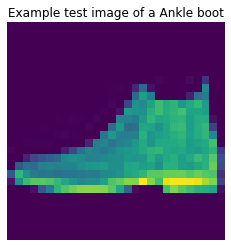

In [ ]:
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig, ax = plt.subplots()
ax.imshow(test_images_raw[0])
ax.axis('off')  # clear x-axis and y-axis
ax.set_title("Example test image of a " + str(labeldict[test_labels[0]]))
print("Shape of a single training image before preprocessing: " + str(train_images_raw[0].shape))
print("Shape of training image dataset: " + str(train_images_raw.shape))
print("Shape of test image dataset: " + str(test_images_raw.shape))
print("Maximum pixel value: " + str(np.max(train_images_raw[0])))
print("Minimum pixel value: " + str(np.min(train_images_raw[0])))

Perform necessary or beneficial preprocessing steps.
> normalize the values of the images, i.e. rescale them to the range [0,1] :

>> converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value (i.e. 255)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(train_images_raw)
test_images = tf.data.Dataset.from_tensor_slices(test_images_raw)
train_data = train_data.map(lambda x: tf.expand_dims(tf.cast(x/255,tf.float32),-1))
test_images = test_images.map(lambda x: tf.expand_dims(tf.cast(x/255,tf.float32),-1))
test_images_tsne = test_images

# print the shape of a training image
print("Shape and dtype of a single training image after preprocessing: " + str(train_data.take(1))) 

# shuffle the dataset to make coherences unlikely
# in the end, we use batching and prefetching to make the further training easier and the runtime faster
train_data = train_data.shuffle(64).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_data = test_images.shuffle(64).batch(32).prefetch(tf.data.experimental.AUTOTUNE)


Shape and dtype of a single training image after preprocessing: <TakeDataset shapes: (28, 28, 1), types: tf.float32>


In [ ]:
# print the shape of a batched training image
for img in train_data.take(1):
  print("Shape of a training dataset element after preprocessing: " + str(img.shape))

test_images = test_images.shuffle(buffer_size=128)
for img in test_images.take(1):
  print("Shape of a single test image: " + str(img.shape))

Shape of a training dataset element after preprocessing: (32, 28, 28, 1)
Shape of a single test image: (28, 28, 1)


# 2 Model

Implement a convolutional autoencoder (and a variational autoencoder for an outstand-
ing).

### 2.1 Convolutional Autoencoder

- The Autoencoder should consist of an encoder and a decoder, which can be called
independently. 

- Encoder: The encoder should reduce the size of featuremaps like a CNN. At the
end of the encoder, 
atten the feature maps and use a dense layer to produce an
embedding of a certain size. 

- Decoder: The decoder takes the embedding from the encoder as input. Use a
dense layer to restore the dimensionality of the 
attened feature maps from the
encoder and reshape the resulting vector into feature maps again. Use upsampling
or transposed convolutions to mirror your encoder. As an output layer use a
convolutional layer with one filter and sigmoid activation to produce an output
image.

### 2.2 (Variational Autoencoder)

For the implementation of a Variational Autoencoder refer to online sources. There are
good tutorials that do a better job at explaining the implementation than we can do in
a few lines of text here. There are also different ways to implement VAEs in tensorflow.

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Encoder(Model): 
  """we have build the Encoder for both types of Autoencoders in one class, the respective part will
  be called when necessary.
  Here, the model learns how to reduce the input dimensions and compress the input data into an encoded representation.
  The compressed image is the distorted version of the original image.
  """
  def __init__(self,code_dims,filter_1,filter_2):
    super(Encoder, self).__init__()
    """We define the layers in the instructor of the class and call them later"""
    # Define the layers.
    self.hiddenlayers = []

    self.hiddenlayers = [tf.keras.layers.Conv2D(filters=filter_1,kernel_size=3,
                                              input_shape=(28,28,1),
                                              padding='same',
                                              ),
                        tf.keras.layers.BatchNormalization(),
                        tf.keras.activations.relu,
                        tf.keras.layers.MaxPooling2D(),
                        tf.keras.layers.Conv2D(filters=filter_2,kernel_size=3,
                                              padding='same',
                                              ),
                        tf.keras.layers.BatchNormalization(),
                        tf.keras.activations.relu,
                        tf.keras.layers.MaxPooling2D(),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(code_dims,activation=tf.keras.activations.softmax)
                      ]


  @tf.function
  def call(self,x,training=True):
    """Here, we just call all our layers, which we defined above, either the first pack of hidden layers or the second
    Depending on what kind of Autoencoder we are currently running 
    """
    for layer in self.hiddenlayers:
      if isinstance(layer, tf.keras.layers.BatchNormalization):
        x = layer(x,training)
      else:
        x = layer(x)
    return x

In [ ]:
class Decoder(Model):
  """This Decoder is responsible for reconstructing the input back to the original dimensions from the code.
  """
  def __init__(self,code_dims,filter_2,filter_1):
        super(Decoder, self).__init__()
        """Same structure as the Encoder"""

        self.hiddenlayers = [tf.keras.layers.Dense(units=7*7*filter_2,input_shape=(code_dims,1),
                                                  activation='relu'
                                                  ),
                            tf.keras.layers.Reshape((7,7,filter_2)),
                            tf.keras.layers.Conv2DTranspose(filter_2, kernel_size=3, 
                                                            strides=2, 
                                                            padding='same',
                                                            ),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.activations.relu,
                            tf.keras.layers.Conv2DTranspose(filter_1, kernel_size=3, 
                                                            strides=2, 
                                                            activation='relu', 
                                                            padding='same',
                                                            ),
                            tf.keras.layers.Conv2D(1, kernel_size=3, 
                                                  padding='same',
                                                  activation='sigmoid')
                            ]
        

  @tf.function
  def call(self,x,training=True):
    for layer in self.hiddenlayers:
      if isinstance(layer, tf.keras.layers.BatchNormalization):
        x = layer(x,training)
      else:
        x = layer(x)
    return x

In [ ]:
class AutoencoderCNN(Model):
  """Convolutional Autoencoder.
  Convolutional Autoencoders learn to encode the input 
  in a set of simple signals and then reconstruct the input from them. 
  """

  def __init__(self,code_dims=10,filter_1=16,filter_2=8):
    """Initialize the Convolutional Autoencoder, it entails an Encoder and Decoder"""
    super(AutoencoderCNN,self).__init__()
    self.encoder = Encoder(code_dims,filter_1,filter_2)
    self.decoder = Decoder(code_dims,filter_1,filter_2)
 
  @tf.function
  def call(self,x,training=True):
    """Define our Autoencoder propagating the input through the 
    Encoder and Decoder respectively
    """
    x = self.encoder(x,training)
    x = self.decoder(x,training)
    return x

# 3 Training

Then train your network(s). Autoencoders learn unsupervised and do not use the la-
bels. Compute the loss between the input image and the reconstructed image. While
training it is nice to plot some example images from the test set with their reconstructed
counterparts to visualize the training progress.

In [ ]:
def train_step(model, noisy_input, input, optimizer, loss_function):

  
  """ Perform a training step for a given Neural Network by
    1. Propagating the input through the network
    2. Calculating the loss between the networks output and the true targets 
    3. Performing Backpropagation and Updating the trainable variables with the calculated gradients 
    """
  with tf.GradientTape() as tape:
    prediction = model(noisy_input)
    loss = loss_function(input,prediction) # + tf.reduce_sum(model.losses)
    gradients = tape.gradient(loss,model.trainable_variables)
  optimizer.apply_gradients(zip(gradients,model.trainable_variables))
  return loss

def test(model,input,loss_function):
  """Test the model for the given data and computes the loss through a given 
  loss function"""
  test_losses = []
  for img in input:
    prediction = model(img,training=False)
    test_loss = loss_function(img,prediction)
    test_losses.append(test_loss.numpy())
  return np.mean(test_losses)

def compare_images(input,model,loss_function,n_images):
  """iterate over n_images images and plot original vs. reconstruction"""

  for i_n in input.take(n_images):

    input = np.reshape(i_n[0].numpy(),(1,28,28,1))
    noise = np.random.normal(loc=0.0, scale=1.0, size=input.shape)
    noisy_input = np.clip(input + 0.25 * noise, 0., 1.)
    output = model(noisy_input)

    print("Loss on following test example: " + str(loss_function(input,output)))
    fig,ax = plt.subplots(ncols = 3)

    # we plot the original images on the very left to be able to draw a comparison
    ax[0].imshow(tf.squeeze(input))
    ax[0].set_title("Original Input")
    ax[0].axis('off')

    # in the middle, we add noise to the input, which we use for training
    ax[1].imshow(tf.squeeze(noisy_input))
    ax[1].set_title("Input + Noise")
    ax[1].axis('off')

    # on the right side, we plot the reconstruction of the original image from the noisy input
    ax[2].imshow(tf.squeeze(output))
    ax[2].set_title("Reconstructed Output")
    ax[2].axis('off')

    plt.show()
  

Epoch: __1
Example image reconstructions after previous training:

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Loss on following test example: tf.Tensor(0.32951978, shape=(), dtype=float32)


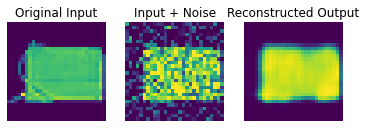

Epoch: __2
Example image reconstructions after previous training:
Loss on following test example: tf.Tensor(0.2789317, shape=(), dtype=float32)


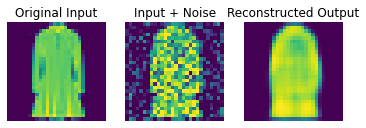

Epoch: __3
Example image reconstructions after previous training:
Loss on following test example: tf.Tensor(0.116770685, shape=(), dtype=float32)


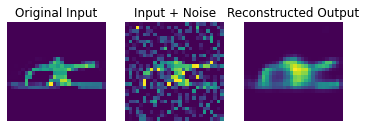

Epoch: __4
Example image reconstructions after previous training:
Loss on following test example: tf.Tensor(0.2773798, shape=(), dtype=float32)


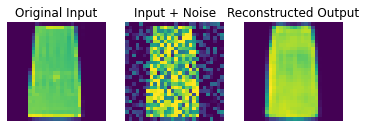

Epoch: __5
Example image reconstructions after previous training:
Loss on following test example: tf.Tensor(0.20463602, shape=(), dtype=float32)


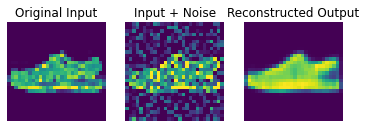

Epoch: __6
Example image reconstructions after previous training:
Loss on following test example: tf.Tensor(0.2201453, shape=(), dtype=float32)


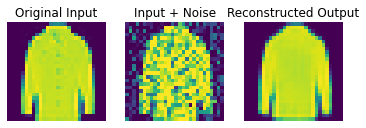

Epoch: __7
Example image reconstructions after previous training:
Loss on following test example: tf.Tensor(0.43248522, shape=(), dtype=float32)


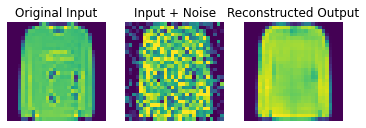

Epoch: __8
Example image reconstructions after previous training:
Loss on following test example: tf.Tensor(0.15565734, shape=(), dtype=float32)


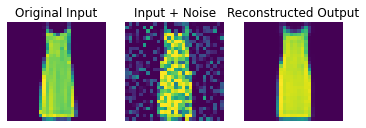

Epoch: __9
Example image reconstructions after previous training:
Loss on following test example: tf.Tensor(0.27672935, shape=(), dtype=float32)


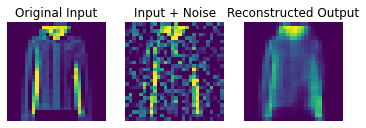

Epoch: __10
Example image reconstructions after previous training:
Loss on following test example: tf.Tensor(0.35743728, shape=(), dtype=float32)


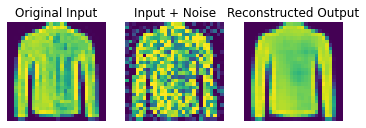

In [ ]:
tf.keras.backend.clear_session()


### Hyperparameters
num_epochs = 10
learning_rate = 0.001
running_average_factor = 0.95

# Initialize the optimizer: Adam with default parameters.
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize the loss: Binary Cross Entropy Loss
# f_loss = tf.keras.losses.MeanSquaredError()
f_loss= tf.keras.losses.BinaryCrossentropy()
code_dims = 128

# Initialize the model.
cnnae = AutoencoderCNN(code_dims,filter_1=32,filter_2=64)

# Initialize lists for later visualization.
train_losses = []
test_losses = []

#testing once before we begin and 
# check how model performs on train data once before we begin
test_loss = test(cnnae,test_data,f_loss)
train_loss = test(cnnae,train_data,f_loss)
test_losses.append(test_loss)
train_losses.append(test_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
  print("Epoch: __" + str(epoch+1))
  running_average_loss = 0
  
  #training (and checking in with training)
  for input in train_data:
      noise = np.random.normal(loc=0.0, scale=1.0, size=input.shape)
      noisy_input = np.clip(input + 0.25 * noise, 0., 1.)   
      train_loss = train_step(cnnae, noisy_input, input, optimizer, f_loss)
      running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
  train_losses.append(running_average_loss)

  #testing
  test_loss = test(cnnae,test_data,f_loss)
  test_losses.append(test_loss)

  print("Example image reconstructions after previous training:")

  #plot test example
  compare_images(test_data,cnnae,f_loss,1)


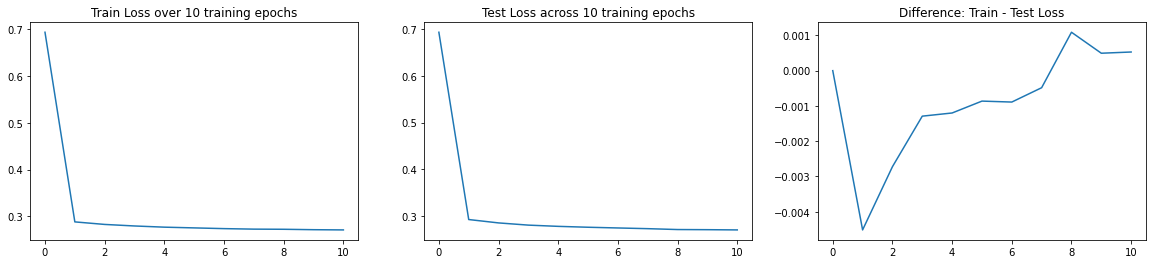

In [ ]:
def plot_losses(num_epochs,train_losses,test_losses):
  """We plot our losses in a comparative graph"""

  fig, ax = plt.subplots(1,3,figsize=(20,4))
  
  ax[0].plot(np.asarray(train_losses))
  ax[0].set_title("Train Loss over " + str(num_epochs) + " training epochs")
  
  ax[1].plot(test_losses)
  ax[1].set_title("Test Loss across " + str(num_epochs) + " training epochs")
  
  loss_diff = np.asarray([train - test for train, test in zip(train_losses,test_losses)])
  ax[2].plot(loss_diff)
  ax[2].set_title("Difference: Train - Test Loss")
  
  plt.show()

plot_losses(num_epochs,train_losses,test_losses)

In [ ]:
cnnae.summary()
cnnae.encoder.summary()
cnnae.decoder.summary()

Model: "autoencoder_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  420736    
_________________________________________________________________
decoder (Decoder)            multiple                  230721    
Total params: 651,457
Trainable params: 651,201
Non-trainable params: 256
_________________________________________________________________
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  320       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
__________________________

# 4 Latent Space Analysis

**Embed the first 1000 images of the test set using the encoder**.  
Reduce the **dimensionality of the embeddings to two** using the t-SNE algorithm.

Then **plot the data points, colored according to their class**. 
Evaluate the result. Is it what you expected? How is this related to the courseware content?  

Further **interpolate linearly between the embeddings of two images and plot the reconstructed images**.  
Again relate this to the courseware content.

In [ ]:
from sklearn.manifold import TSNE
test_tsne = test_images_tsne.take(1000)
cnnae_codes = [cnnae.encoder(tf.expand_dims(test_image,0)) for test_image in test_tsne]
cnnae_codes = tf.squeeze(cnnae_codes).numpy()
codes_tsne_cnnae_embedded = TSNE(n_components=2).fit_transform(cnnae_codes)

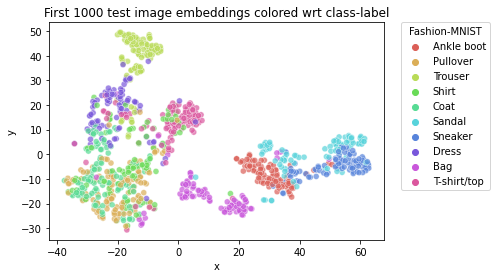

In [ ]:
import seaborn as sns
import pandas as pd
def visualize_tsne(codes_tsne):
  """We plot the first 1000 test image embeddings
  to see how well the training performed"""
  embedding_labels = test_labels[:1000]
  df_tsne = pd.DataFrame()
  df_tsne['x'] = codes_tsne[:,0]
  df_tsne['y'] = codes_tsne[:,1]
  df_tsne['label'] = embedding_labels
  df_tsne['Fashion'] = df_tsne['label'].map(labeldict)
  fig, ax = plt.subplots()
  sns.scatterplot(x='x', y='y',
                  hue='Fashion', palette=sns.color_palette("hls",10),
                  data=df_tsne, legend="full", alpha=0.7
                  )
  ax.set_title("First 1000 test image embeddings colored wrt class-label")
  plt.legend(title="Fashion-MNIST", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.show()

visualize_tsne(codes_tsne_cnnae_embedded)

### Evaluate the result. Is it what you expected? How is this related to the courseware content?

The results shown in the scatter plot show pretty much the common distinctions and similarities between the different clothes. The embedded clothes that have overall a similar shape, e.g. shoes overall, are plotted close together. 

The plots of bags, for instance, do not show major similarities with any other type. Thus, they are also in our scatter plot further apart and pretty much isolated. 

In [ ]:
def interpolate(encoder,decoder, code_dim = 128, img1=0,img2=0,code1=0,code2=0,vae=False):
  for i,img in enumerate(test_tsne):
    if i == 0:
      img1 = img
      if (vae==False):
        code1 = encoder(tf.expand_dims(img1,0),training=False)
      else:
        _,_,code1 = encoder(tf.expand_dims(img1,0))
    elif i == 1:
      img2 = img
      if (vae==False):
        code2 = encoder(tf.expand_dims(img2,0),training=False)
      else:
        _,_,code2 = encoder(tf.expand_dims(img2,0))
    else:
      break
  interpolated = (code1+code2)/2
  decoded_interpolation = decoder(np.reshape(interpolated,(1,code_dim)))
  return img1,img2,decoded_interpolation,code1,code2,interpolated

def visualize_interpolation(decoder,img1,img2,code_dim,decoded_interpolation,code1,code2):
  fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,4))
  ax[0,0].imshow(tf.squeeze(img1))
  ax[0,1].imshow(tf.squeeze(img2))
  ax[0,2].imshow(tf.squeeze(decoded_interpolation))
  ax[0,0].set_title("Image 1: " + labeldict[test_labels[0]])
  ax[0,0].set_axis_off()
  ax[0,1].set_title("Image 2: " + labeldict[test_labels[1]])
  ax[0,1].set_axis_off()
  ax[0,2].set_title("Interpolation between embeddings")
  ax[0,2].set_axis_off()
  ax[1,0].imshow(tf.squeeze(decoder(np.reshape(code1,(1,code_dim)))))
  ax[1,1].imshow(tf.squeeze(decoder(np.reshape(code2,(1,code_dim)))))
  ax[1,2].imshow(tf.squeeze(decoded_interpolation))
  ax[1,0].set_title("Image 1 decoded")
  ax[1,0].set_axis_off()
  ax[1,1].set_title("Image 2 decoded")
  ax[1,1].set_axis_off()
  ax[1,2].set_axis_off()

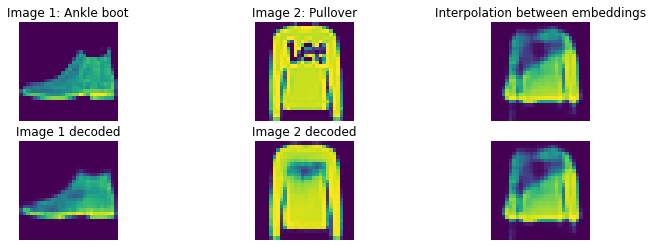

In [ ]:
img1,img2,decoded_interpolation,code1,code2,interpolated = interpolate(cnnae.encoder,cnnae.decoder,code_dim=code_dims)
visualize_interpolation(cnnae.decoder,img1,img2,code_dims,decoded_interpolation,code1,code2)

# Variational Autoencoder

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding of a fashion item as a layer."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# define the encoder
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# define the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_3[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_4[0][0]                   
____________________________________________________________________________________________

In [ ]:
# define the VAE (encoder and decoder combined in a new Model subclass) with train step
class VAE(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28

            # we need to compute the kulback-leibler divergence for the loss
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
# train the VAE
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
mnist_pieces = np.concatenate([x_train, x_test], axis=0)
mnist_pieces = np.expand_dims(mnist_pieces, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_pieces, epochs=10, batch_size=128)

Epoch 1/10
547/547 [==============================] - 4s 8ms/step - loss: 269.4996 - reconstruction_loss: 265.0320 - kl_loss: 4.4676
Epoch 2/10
547/547 [==============================] - 4s 7ms/step - loss: 267.4590 - reconstruction_loss: 263.1750 - kl_loss: 4.2840
Epoch 3/10
547/547 [==============================] - 4s 7ms/step - loss: 266.2035 - reconstruction_loss: 261.9967 - kl_loss: 4.2068
Epoch 4/10
547/547 [==============================] - 4s 7ms/step - loss: 265.1231 - reconstruction_loss: 260.9494 - kl_loss: 4.1737
Epoch 5/10
547/547 [==============================] - 4s 7ms/step - loss: 264.3476 - reconstruction_loss: 260.1960 - kl_loss: 4.1517
Epoch 6/10
547/547 [==============================] - 4s 7ms/step - loss: 263.5060 - reconstruction_loss: 259.3880 - kl_loss: 4.1179
Epoch 7/10
547/547 [==============================] - 4s 7ms/step - loss: 262.8554 - reconstruction_loss: 258.7521 - kl_loss: 4.1033
Epoch 8/10
547/547 [==============================] - 4s 7ms/step - l

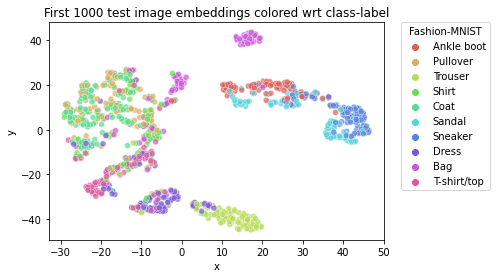

In [ ]:
# TSNE
vae_codes = [vae.encoder(tf.expand_dims(test_image,0))[2].numpy().reshape((2,)) for test_image in test_tsne]
vae_codes = np.asarray(vae_codes)
codes_tsne_vae_embedded = TSNE(n_components=2).fit_transform(vae_codes)
visualize_tsne(codes_tsne_vae_embedded)

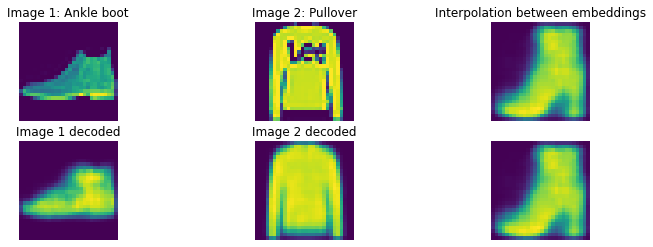

In [ ]:
# image interpolation
img1,img2,decoded_interpolation,code1,code2,interpolated = interpolate(vae.encoder,vae.decoder,latent_dim,vae=True)
visualize_interpolation(vae.decoder,img1,img2,latent_dim,decoded_interpolation,code1,code2)

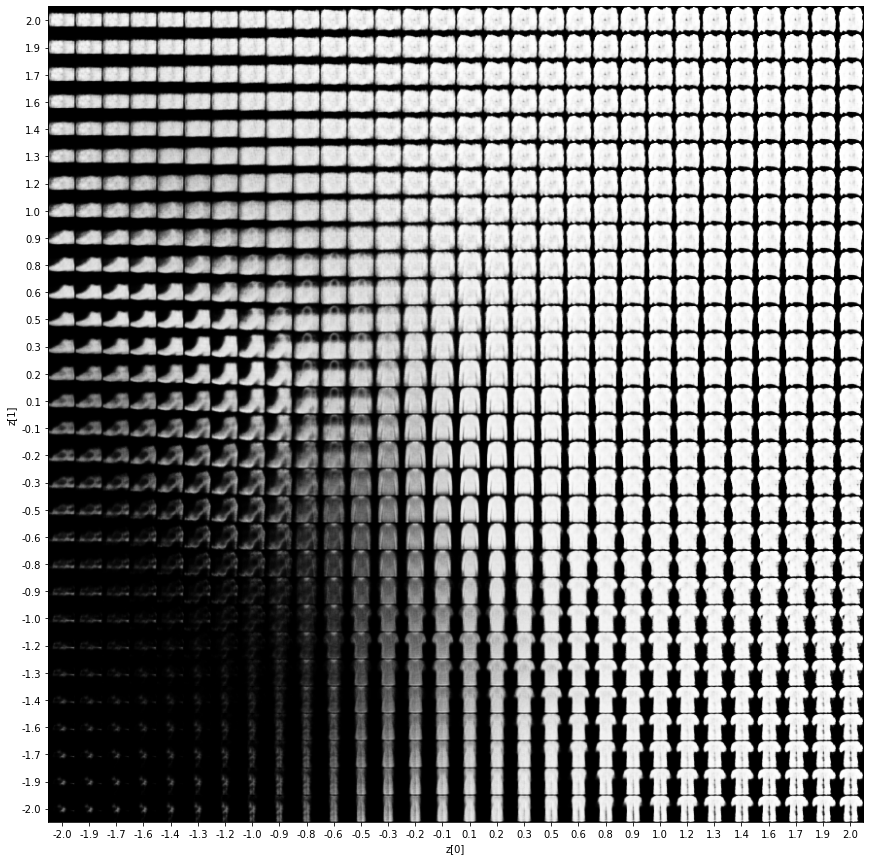

In [ ]:
def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent(vae.encoder, vae.decoder)

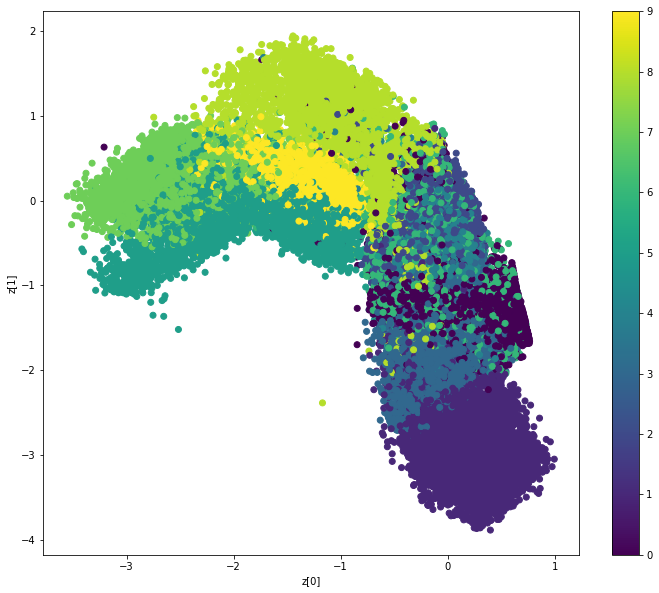

In [ ]:
def plot_label_clusters(encoder, decoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae.encoder, vae.decoder, x_train, y_train)
